## Testsite for more advanced ML schemes

- Henrik testing CNN

In [154]:
# Different useful libraries
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helpers
from helpers import *
%run helpers.py

#### Get the augmented data

In [10]:
# Load images
cups, cup_size = import_images(path='henriks_images/augment_cup/')
boxes, box_size = import_images(path='henriks_images/augment_box/')

In [14]:
# Balance the data - we have more box data then cup data
idx = np.random.randint(0, len(cups), len(cups))
cups = np.asarray(cups)[idx, :, :, 0]
boxes = np.asarray(boxes)[idx, :, :, 0]
cups.shape, boxes.shape

((2970, 128, 128), (2970, 128, 128))

### Basic data formatting
Splitting, normalization, pandas etc.

In [80]:
# Normalize advanced approach
(scaled_boxes, scaled_cups), scaler = normalize_2D(all_data=[boxes, cups], scaler_type='minmax')
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.0 0.9715447154471546 ) cups:( 0.11344537815126049 1.0 )


In [84]:
# Normalize ez approach
scaled_boxes = boxes / 255
scaled_cups = cups / 255
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.0 0.9725490196078431 ) cups:( 0.13333333333333333 1.0 )


In [85]:
image_df = from_numpy_to_pd(data=[scaled_cups, scaled_boxes], labels=[0, 1])

In [114]:
train, test = train_test_split(image_df, test_size=0.2)

x_train = np.stack(train['data'], 0)
y_train = np.float32(train['label'])

x_test = np.stack(test['data'], 0)
y_test = np.float32(test['label'])

# For Keras this is required:
a, b, c = x_train.shape
x_train = x_train.reshape((a,b,c,1))
a, b, c = x_test.shape
x_test = x_test.reshape((a,b,c,1))


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4752, 128, 128, 1), (4752,), (1188, 128, 128, 1), (1188,))

### CNN - *conv. neural net time baby*!

***NB!*** Since we are for now only doing binary classification:
```
1. Change Categorical Cross Entropy to Binary Cross Entropy since your output label is binary.
2. Change Softmax to Sigmoid since Sigmoid is the proper activation function for binary data
```

Good sources:

- CONVNET on MINST: https://keras.io/examples/vision/mnist_convnet/
- Binary classification: https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

In [141]:
input_shape = (128, 128, 1)

cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="sigmoid"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

#cnn_model.summary()

In [142]:
batch_size = 32
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history = cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=1,
            #callbacks=[early_stop, PrintDot()]
            )

Epoch 1/50
134/134 [==============================] - 32s 235ms/step - loss: 0.6240 - accuracy: 0.6205 - val_loss: 0.4069 - val_accuracy: 0.8046
Epoch 2/50
134/134 [==============================] - 33s 244ms/step - loss: 0.3111 - accuracy: 0.8627 - val_loss: 0.2504 - val_accuracy: 0.8824
Epoch 3/50
134/134 [==============================] - 31s 232ms/step - loss: 0.1993 - accuracy: 0.9212 - val_loss: 0.1699 - val_accuracy: 0.9265
Epoch 4/50
134/134 [==============================] - 29s 216ms/step - loss: 0.1630 - accuracy: 0.9337 - val_loss: 0.1275 - val_accuracy: 0.9580
Epoch 5/50
134/134 [==============================] - 28s 210ms/step - loss: 0.1117 - accuracy: 0.9648 - val_loss: 0.1263 - val_accuracy: 0.9391
Epoch 6/50
134/134 [==============================] - 28s 210ms/step - loss: 0.1021 - accuracy: 0.9644 - val_loss: 0.0861 - val_accuracy: 0.9790
Epoch 7/50
134/134 [==============================] - 28s 209ms/step - loss: 0.0859 - accuracy: 0.9706 - val_loss: 0.0744 - val_ac

,loss,accuracy,val_loss,val_accuracy,epoch
49,0.009653,0.997428,0.04284,0.991597,49


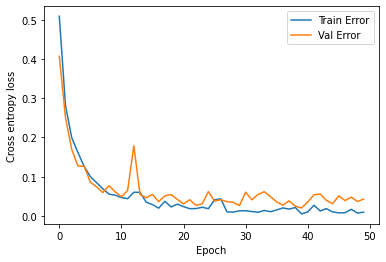

In [143]:
show_final_score(cnn_history)

In [145]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.06961480528116226
Test accuracy: 0.9806397557258606


#### Test results
**Simple** Runs: with batch size 32, epochs 15
- Using softmax in output layer and sparse_categorical_crossentropy loss:\
    ```[Test loss: 0.050683144479990005, Test accuracy: 0.9806397557258606]```
- Trying the sigmoid output and sparse_categorical_crossentropy loss:\
    ```[Test loss: 0.08819699287414551, Test accuracy: 0.9713804721832275]```
- Binary cross entropy failed...

"**Advanced**" Using ealy stopping got about the same results

### Try out model on the real data!

In [155]:
from helpers import *
%run helpers.py

In [166]:
# Load raw images
real_cups, real_cup_size = import_images(path='test_samples/cups/')
real_boxes, real_box_size = import_images(path='test_samples/boxes/')
# Reshape
real_cups = resize_and_flatten(real_cups, padding=False, max_size=real_cup_size, output_size=128, flatten=False)
real_boxes = resize_and_flatten(real_boxes, padding=False, max_size=real_box_size, output_size=128, flatten=False)
# Scale
real_cups = real_cups / 255
real_boxes = real_boxes / 255
# Shape for KERAS
a, b, c = real_cups.shape
real_cups = real_cups.reshape((a,b,c,1))
a, b, c = real_boxes.shape
real_boxes = real_boxes.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((6,))
box_target = np.zeros((6,))

# Combine the data
data = np.concatenate((real_cups, real_boxes))
targets = np.concatenate((cup_target, box_target))

data.shape, targets.shape

((12, 128, 128, 1), (12,))

In [168]:
score = cnn_model.evaluate(data, targets, verbose=0)
#print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test accuracy: 0.5
